# Machine Learning Foundation

## Course 3, Part a: Logistic Regression LAB


## Introduction

We will be using the [Human Activity Recognition with Smartphones](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML241ENSkillsNetwork31576874-2022-01-01) database, which was built from the recordings of study participants who carried a smartphone with an embedded inertial sensor while performing activities of daily living (ADL). The objective is to classify the activities the participants performed into one of the six following categories: walking, walking upstairs, walking downstairs, sitting, standing, and laying.

The following information is provided for each record in the dataset:

*   Triaxial acceleration from the accelerometer (total acceleration) and the estimated body acceleration
*   Triaxial Angular velocity from the gyroscope
*   A 561-feature vector with time and frequency domain variables
*   The activity label

More information about the features are available on the website linked above.


In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [2]:
import seaborn as sns, pandas as pd, numpy as np

## Question 1

Import the data and do the following:

*   Examine the data types--there are many columns, so it might be wise to use value counts.
*   Determine if the floating point values need to be scaled.
*   Determine the breakdown of each activity.
*   Encode the activity label as an integer.


In [3]:
### BEGIN SOLUTION
#data = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML241EN-SkillsNetwork/labs/datasets/Human_Activity_Recognition_Using_Smartphones_Data.csv", sep=',')
data = pd.read_csv("Human_Activity_Recognition_Using_Smartphones_Data.csv", sep=',')

The data columns are all floats except for the activity label.


In [4]:
data.dtypes.value_counts()

float64    561
object       1
Name: count, dtype: int64

In [5]:
data.dtypes.tail()

angle(tBodyGyroJerkMean,gravityMean)    float64
angle(X,gravityMean)                    float64
angle(Y,gravityMean)                    float64
angle(Z,gravityMean)                    float64
Activity                                 object
dtype: object

The data are all scaled from -1 (minimum) to 1.0 (maximum).


In [6]:
data.iloc[:, :-1].min().value_counts()

-1.0    561
Name: count, dtype: int64

In [7]:
data.iloc[:, :-1].max().value_counts()

1.0    561
Name: count, dtype: int64

Examine the breakdown of activities; they are relatively balanced.


In [8]:
data.Activity.value_counts()

Activity
LAYING                1944
STANDING              1906
SITTING               1777
WALKING               1722
WALKING_UPSTAIRS      1544
WALKING_DOWNSTAIRS    1406
Name: count, dtype: int64

Scikit learn classifiers won't accept a sparse matrix for the prediction column. Thus, either `LabelEncoder` needs to be used to convert the activity labels to integers, or if `DictVectorizer` is used, the resulting matrix must be converted to a non-sparse array.\
Use `LabelEncoder` to fit_transform the "Activity" column, and look at 5 random values.


In [9]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
data['Activity'] = le.fit_transform(data.Activity)
data['Activity'].sample(5)
### END SOLUTION

3420    5
3552    3
7270    3
1167    2
9544    5
Name: Activity, dtype: int32

## Question 2

*   Calculate the correlations between the dependent variables.
*   Create a histogram of the correlation values.
*   Identify those that are most correlated (either positively or negatively).


In [10]:
### BEGIN SOLUTION
# Calculate the correlation values
feature_cols = data.columns[:-1]
corr_values = data[feature_cols].corr()

# Simplify by emptying all the data below the diagonal
tril_index = np.tril_indices_from(corr_values)

# Make the unused values NaNs
for coord in zip(*tril_index):
    corr_values.iloc[coord[0], coord[1]] = np.NaN
    
# Stack the data and convert to a data frame
corr_values = (corr_values
               .stack()
               .to_frame()
               .reset_index()
               .rename(columns={'level_0':'feature1',
                                'level_1':'feature2',
                                0:'correlation'}))

# Get the absolute values for sorting
corr_values['abs_correlation'] = corr_values.correlation.abs()

A histogram of the absolute value correlations.


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

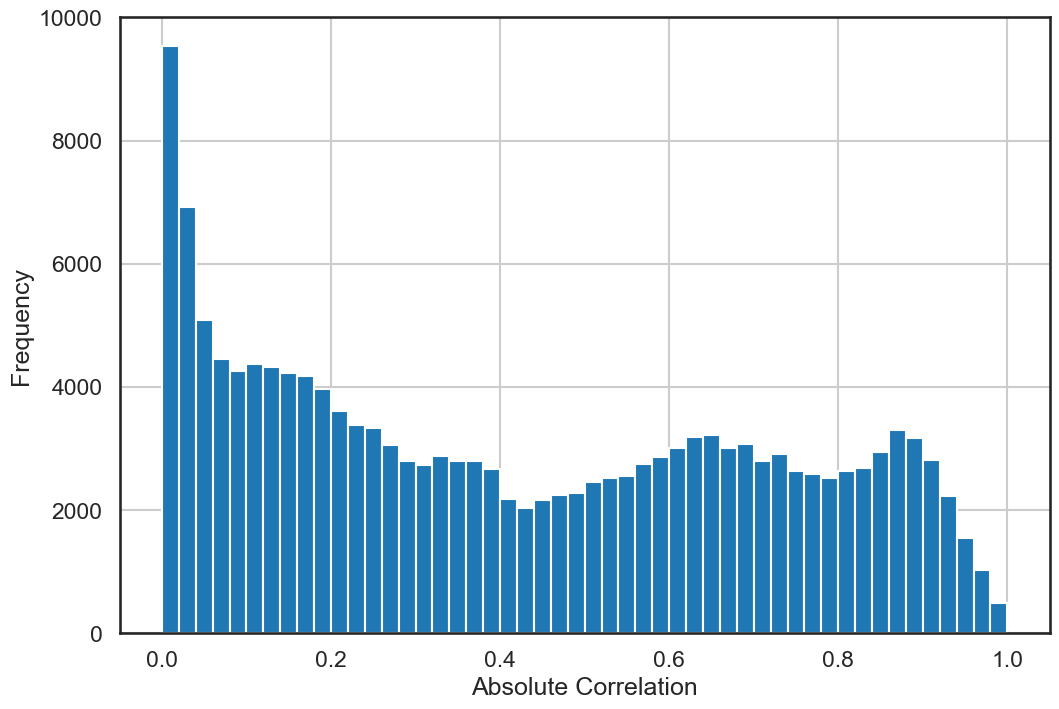

In [12]:
sns.set_context('talk')
sns.set_style('white')

ax = corr_values.abs_correlation.hist(bins=50, figsize=(12, 8))
ax.set(xlabel='Absolute Correlation', ylabel='Frequency');

In [13]:
# The most highly correlated values
corr_values.sort_values('correlation', ascending=False).query('abs_correlation>0.8')
### END SOLUTION

,feature1,feature2,correlation,abs_correlation
156894,fBodyBodyGyroJerkMag-mean(),fBodyBodyGyroJerkMag-sma(),1.000000,1.000000
93902,tBodyAccMag-sma(),tGravityAccMag-sma(),1.000000,1.000000
101139,tBodyAccJerkMag-mean(),tBodyAccJerkMag-sma(),1.000000,1.000000
96706,tGravityAccMag-mean(),tGravityAccMag-sma(),1.000000,1.000000
94257,tBodyAccMag-energy(),tGravityAccMag-energy(),1.000000,1.000000
...,...,...,...,...
22657,tGravityAcc-mean()-Y,"angle(Y,gravityMean)",-0.993425,0.993425
39225,"tGravityAcc-arCoeff()-Z,3","tGravityAcc-arCoeff()-Z,4",-0.994267,0.994267
38739,"tGravityAcc-arCoeff()-Z,2","tGravityAcc-arCoeff()-Z,3",-0.994628,0.994628
23176,tGravityAcc-mean()-Z,"angle(Z,gravityMean)",-0.994764,0.994764


## Question 3

*   Split the data into train and test data sets. This can be done using any method, but consider using Scikit-learn's `StratifiedShuffleSplit` to maintain the same ratio of predictor classes.
*   Regardless of the method used to split the data, compare the ratio of classes in both the train and test splits.


In [14]:
### BEGIN SOLUTION
from sklearn.model_selection import StratifiedShuffleSplit

# Get the split indexes
strat_shuf_split = StratifiedShuffleSplit(n_splits=1, 
                                          test_size=0.3, 
                                          random_state=42)

train_idx, test_idx = next(strat_shuf_split.split(data[feature_cols], data.Activity))

# Create the dataframes
X_train = data.loc[train_idx, feature_cols]
y_train = data.loc[train_idx, 'Activity']

X_test  = data.loc[test_idx, feature_cols]
y_test  = data.loc[test_idx, 'Activity']

In [15]:
y_train.value_counts(normalize=True)

Activity
0    0.188792
2    0.185046
1    0.172562
3    0.167152
5    0.149951
4    0.136496
Name: proportion, dtype: float64

In [16]:
y_test.value_counts(normalize=True)
### END SOLUTION

Activity
0    0.188673
2    0.185113
1    0.172492
3    0.167314
5    0.149838
4    0.136570
Name: proportion, dtype: float64

## Question 4

*   Fit a logistic regression model without any regularization using all of the features. Be sure to read the documentation about fitting a multi-class model so you understand the coefficient output. Store the model.
*   Using cross validation to determine the hyperparameters and fit models using L1 and L2 regularization. Store each of these models as well. Note the limitations on multi-class models, solvers, and regularizations. The regularized models, in particular the L1 model, will probably take a while to fit.


In [17]:
### BEGIN SOLUTION
from sklearn.linear_model import LogisticRegression

# Standard logistic regression
lr = LogisticRegression(solver='liblinear').fit(X_train, y_train)

In [18]:
from sklearn.linear_model import LogisticRegressionCV

# L1 regularized logistic regression
lr_l1 = LogisticRegressionCV(Cs=10, cv=4, penalty='l1', solver='liblinear').fit(X_train, y_train)

In [19]:
# L2 regularized logistic regression
lr_l2 = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', solver='liblinear').fit(X_train, y_train)
### END SOLUTION

## Question 5

*   Compare the magnitudes of the coefficients for each of the models. If one-vs-rest fitting was used, each set of coefficients can be plotted separately.


In [20]:
### BEGIN SOLUTION
# Combine all the coefficients into a dataframe
coefficients = list()

coeff_labels = ['lr', 'l1', 'l2']
coeff_models = [lr, lr_l1, lr_l2]

for lab,mod in zip(coeff_labels, coeff_models):
    coeffs = mod.coef_
    coeff_label = pd.MultiIndex(levels=[[lab], [0,1,2,3,4,5]], 
                                 codes=[[0,0,0,0,0,0], [0,1,2,3,4,5]])
    coefficients.append(pd.DataFrame(coeffs.T, columns=coeff_label))

coefficients = pd.concat(coefficients, axis=1)

coefficients.sample(10)

lr                                                          l1  \
            0         1         2         3         4         5         0   
292  0.175566  0.147579 -0.047788  0.054523  0.262426 -0.285642  0.076541   
389 -0.022998  0.081743  0.077773  0.351469 -0.188037 -0.196099 -0.090734   
333  0.001310  0.230152  0.254187 -0.003959  0.054308  0.265299 -0.223293   
94   0.030394  0.062221  0.302152 -0.762586  0.318511  0.115725  0.021097   
4   -0.045407 -0.034155 -0.451850  0.260230 -0.516844  0.106248 -0.062139   
487  0.001048  0.239755  0.249350 -0.098213  0.346118  0.323537  0.414785   
215  0.082573  0.047831 -0.040873 -0.829970  0.545193 -0.552313  0.009523   
31  -0.062221  0.258954 -0.298634 -0.246104  0.026193  0.257929 -0.396796   
88  -0.034089  0.068083 -0.294508  0.119140  0.209142 -0.556358  0.052043   
507  0.019842 -0.053250 -0.322731 -1.004548  0.877976 -0.633997  0.172783   

                                                             l2            \
            1         2         3         4         5         0         1   
292  0.010622  0.157560  0.000000  0.156467 -0.059922  0.351957 -0.218092   
389  0.000000  0.000000  0.128683  0.270430 -0.083245 -0.055976  0.175834   
333  0.310566  0.314171  0.000000  0.218956  0.266290 -0.019783  0.613708   
94   0.000000  0.000000 -1.332403  0.190625  0.366343  0.052901 -0.592537   
4    0.000000 -1.382902  0.000000 -1.901054  0.019798 -0.035987  0.615185   
487  0.364022  0.254114  0.000000  0.145094  0.090328 -0.020499  0.663853   
215  0.000000  0.000000 -0.312106  0.852723 -1.706499  0.158920  0.174906   
31   0.213035 -0.898257 -0.056711  0.000000  0.550642 -0.138194  1.106044   
88   0.000000  0.000000  0.000000  0.000000 -0.998561 -0.060541  0.450519   
507  0.000000 -0.395706 -1.187200  2.790585 -3.423596  0.051006  0.473715   

                                             
            2         3         4         5  
292  0.369973  0.449929  0.282848 -0.889341  
389  0.039329  1.215699 -0.472805 -0.779755  
333  0.642282 -0.133286  0.099854  1.333084  
94   1.200782 -2.432723  0.892010  0.876109  
4   -1.504112  0.902784 -0.974681  0.147313  
487  0.475154 -0.404973  0.673415  1.480574  
215 -0.270132 -1.927763  0.966809 -2.192560  
31  -1.018910 -0.977664  0.058700  2.095980  
88  -1.113992  0.224129  0.437470 -2.418674  
507 -1.270628 -2.470249  1.625744 -2.882991

Prepare six separate plots for each of the multi-class coefficients.


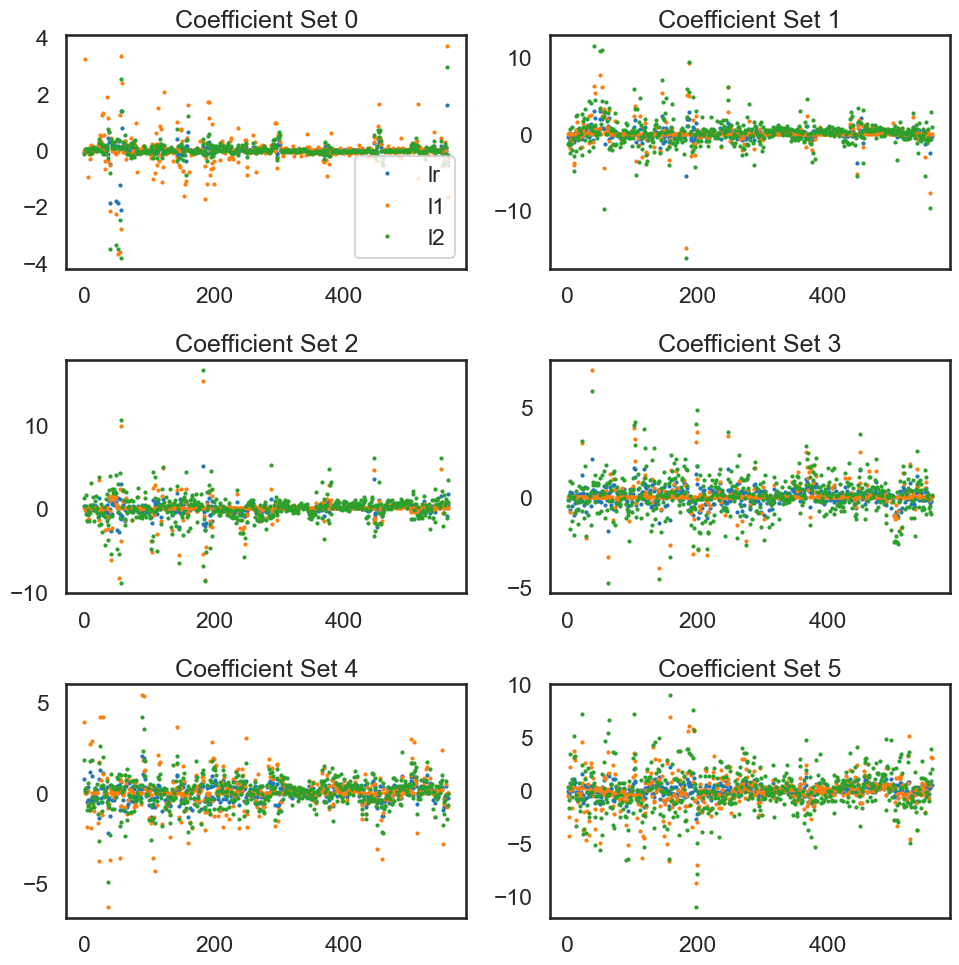

In [21]:
fig, axList = plt.subplots(nrows=3, ncols=2)
axList = axList.flatten()
fig.set_size_inches(10,10)

for ax in enumerate(axList):
    loc = ax[0]
    ax = ax[1]
    
    data = coefficients.xs(loc, level=1, axis=1)
    data.plot(marker='o', ls='', ms=2.0, ax=ax, legend=False)
    
    if ax is axList[0]:
        ax.legend(loc=4)
        
    ax.set(title='Coefficient Set '+str(loc))

plt.tight_layout()
### END SOLUTION

## Question 6

*   Predict and store the class for each model.
*   Store the probability for the predicted class for each model.


In [22]:
### BEGIN SOLUTION
# Predict the class and the probability for each
y_pred = list()
y_prob = list()

coeff_labels = ['lr', 'l1', 'l2']
coeff_models = [lr, lr_l1, lr_l2]

for lab,mod in zip(coeff_labels, coeff_models):
    y_pred.append(pd.Series(mod.predict(X_test), name=lab))
    y_prob.append(pd.Series(mod.predict_proba(X_test).max(axis=1), name=lab))
    
y_pred = pd.concat(y_pred, axis=1)
y_prob = pd.concat(y_prob, axis=1)

y_pred.head()

,lr,l1,l2
0,3,3,3
1,5,5,5
2,3,3,3
3,1,1,1
4,0,0,0


In [23]:
y_prob.head()
### END SOLUTION

,lr,l1,l2
0,0.998939,0.998977,0.999998
1,0.988165,0.999570,0.999477
2,0.987592,0.995520,0.999697
3,0.981381,0.999157,0.999865
4,0.998277,0.999921,0.999997


## Question 7

For each model, calculate the following error metrics:

*   Accuracy
*   Precision
*   Recall
*   F-score
*   Confusion Matrix

Decide how to combine the multi-class metrics into a single value for each model.


In [24]:
### BEGIN SOLUTION
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize

metrics = list()
cm = dict()

for lab in coeff_labels:

    # Preciision, recall, f-score from the multi-class support function
    precision, recall, fscore, _ = score(y_test, y_pred[lab], average='weighted')
    
    # The usual way to calculate accuracy
    accuracy = accuracy_score(y_test, y_pred[lab])
    
    # ROC-AUC scores can be calculated by binarizing the data
    auc = roc_auc_score(label_binarize(y_test, classes=[0,1,2,3,4,5]),
              label_binarize(y_pred[lab], classes=[0,1,2,3,4,5]), 
              average='weighted')
    
    # Last, the confusion matrix
    cm[lab] = confusion_matrix(y_test, y_pred[lab])
    
    metrics.append(pd.Series({'precision':precision, 'recall':recall, 
                              'fscore':fscore, 'accuracy':accuracy,
                              'auc':auc}, 
                             name=lab))

metrics = pd.concat(metrics, axis=1)

In [25]:
metrics
### END SOLUTION

,lr,l1,l2
precision,0.984144,0.983835,0.984477
recall,0.984142,0.983819,0.984466
fscore,0.984143,0.983815,0.984464
accuracy,0.984142,0.983819,0.984466
auc,0.990384,0.990144,0.990553


## Question 8

*   Display or plot the confusion matrix for each model.


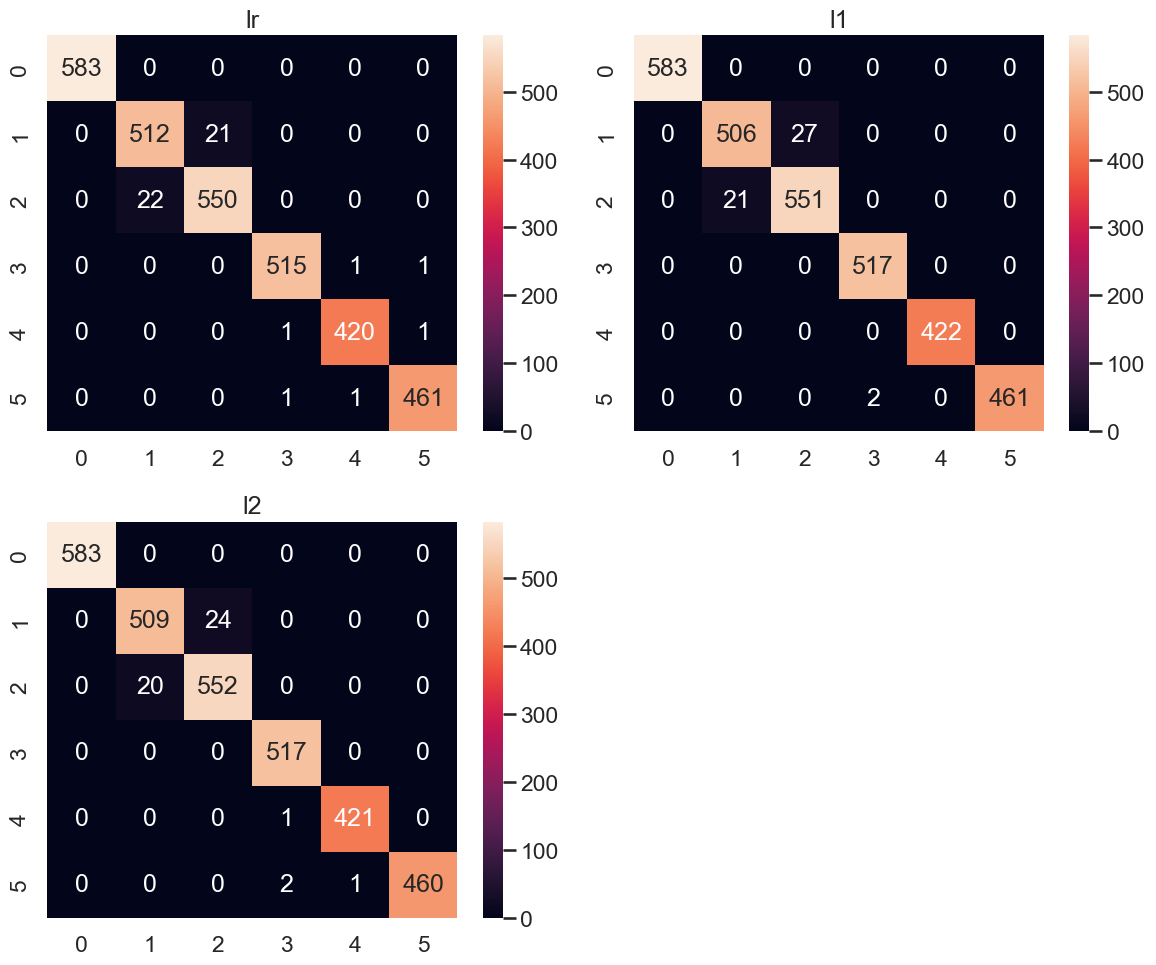

In [26]:
### BEGIN SOLUTION
fig, axList = plt.subplots(nrows=2, ncols=2)
axList = axList.flatten()
fig.set_size_inches(12, 10)

axList[-1].axis('off')

for ax,lab in zip(axList[:-1], coeff_labels):
    sns.heatmap(cm[lab], ax=ax, annot=True, fmt='d');
    ax.set(title=lab);
    
plt.tight_layout()
### END SOLUTION

***

### Machine Learning Foundation (C) 2020 IBM Corporation
